In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point  #Polygon

#y!pip install geopandas
import geopandas

# To use geopandas.tools.sjoin
#!pip uninstall rtree
#!sudo apt install libspatialindex-dev
#!sudo pip3 install rtree

# WMCA + Warrington houses only

In [2]:
df = pd.read_csv("/content/drive/MyDrive/WMCA/data_1012650.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (22,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
house_gdf = geopandas.GeoDataFrame(
    df[['uprn', 'LATITUDE', 'LONGITUDE']],
    geometry=geopandas.points_from_xy(df.LONGITUDE, df.LATITUDE),
    crs='epsg:4326')

In [4]:
uk_shp = geopandas.read_file('/content/drive/MyDrive/WMCA/WMCA Shapefile/LAD_DEC_2021_GB_BFC.shp')
# filter shapefiles
counties = ['Birmingham','Wolverhampton','Coventry','Dudley','Sandwell','Solihull','Walsall']
westmidlands_shp = uk_shp[uk_shp.LAD21NM.isin(counties)] 
# convert to lat/lng
westmidlands_shp = westmidlands_shp.to_crs('epsg:4326') 
# combine shapefiles 
westmidlands_shp_boundary = westmidlands_shp.dissolve() 

In [5]:
# Filter for houses within boundary
houseInWestMidlands = geopandas.tools.sjoin(house_gdf,westmidlands_shp_boundary, how='right')

In [ ]:
# Check that all houses are within region of interest 
fig, ax = plt.subplots(figsize=(7,7))
westmidlands_shp_boundary.plot(
    ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis"
    )
# Reduce points to prevent crashing
plot_points = houseInWestMidlands.drop_duplicates(subset='geometry',inplace=True)
plot_points.plot(ax=ax, color='red', markersize=2, alpha=0.2)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

In [ ]:
# Map of West Midlands
westmidlands_shp.plot(facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")

In [6]:
# Filter out houses outside the region of interest
df = df[df.uprn.isin(houseInWestMidlands.uprn)]

# Dependent variable (EPC rating)

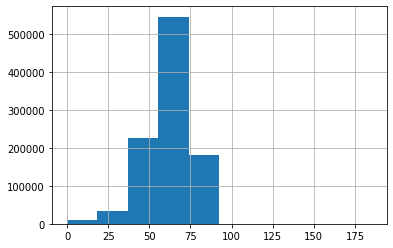

In [7]:
df["current-energy-efficiency"].hist()
plt.show()

In [8]:
# Energy efficiency ratings should only go up to 100
df = df[df["current-energy-efficiency"] <=100]
print(f"Min: {df['current-energy-efficiency'].min()}")
print(f"Max: {df['current-energy-efficiency'].max()}")

Min: 0
Max: 100


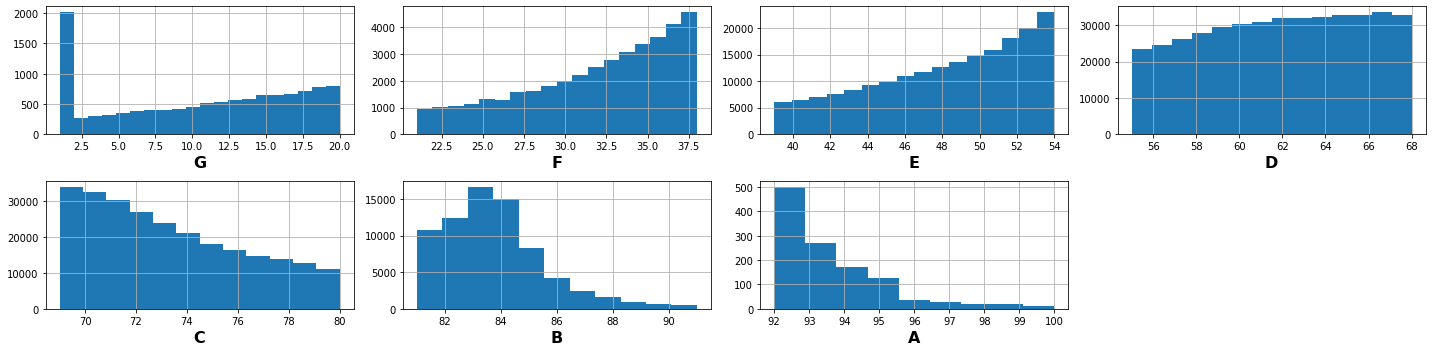

In [9]:
plt.figure(figsize=(20,5))

bands = ['G', 'F', 'E', 'D', 'C', 'B','A']

for i, band in enumerate(bands):
  epc_bands = df[df["current-energy-rating"] == band]
  plt.subplot(241+i)
  bins = len(epc_bands['current-energy-efficiency'].unique())
  epc_bands['current-energy-efficiency'].hist(bins=bins)
  plt.xlabel(band,fontsize=16, weight='bold')

plt.tight_layout()

# Impute missing values

For values which do not change often over time such as `built-form` (detached, terraced etc), it's safe to use the data from previous certificates where available to fill the missing values in more recent certificates.


In [10]:
epc_grouped = df.groupby(['uprn'], as_index=False)['inspection-date'].count()
epc_grouped_2plus = epc_grouped[epc_grouped['inspection-date'] > 1]
epc_2plus = df.merge(epc_grouped_2plus[['uprn']], on = 'uprn', how = 'inner')

In [11]:
# note this takes a while
fill_columns = ['built-form', 'floor-level','number-habitable-rooms','floor-description',
                'roof-description','heat-loss-corridor','walls-description','floor-height',
                'mains-gas-flag']

for c in fill_columns:
    print(c)
    epc_2plus[c] = epc_2plus.groupby(['uprn'], sort=False)[c].apply(lambda x: x.ffill())

built-form
floor-level
number-habitable-rooms
floor-description
roof-description
heat-loss-corridor
walls-description
floor-height
mains-gas-flag


In [12]:
epc_grouped_1 = epc_grouped[epc_grouped['inspection-date'] == 1]
epc_1 = df.merge(epc_grouped_1[['uprn']], on='uprn', how='inner')

In [13]:
# merging filled data for buildings with more than one certificate with data for buildings with only one certificate
epc_filled = pd.concat([epc_1,epc_2plus])

In [14]:
# checking length of filled data (should be the)
print(f"Missing rows: {len(df) - len(epc_filled)}")
print(f"Property without UPRN: {len(df[df.uprn.isna()])}")

Missing rows: 0
Property without UPRN: 0


In [15]:
# remove rows without UPRN, doesn't exist and cannot find data
df = df[df.uprn.isna()==False]

# Standardising missing data labels

In [16]:
# replace 'NO DATA!', 'not defined' and 'not recored' with null
df = df.replace(['NO DATA!','NODATA!'],np.nan)
df = df.replace(['not recorded','not defined','unknown','Unknown','Not defined','Not recorded'],np.nan)
df = df.replace(['N/A','n/a'],np.nan)
df = df.replace(['INVALID!'],np.nan)

# Data Audit
This script takes an audit of the EPC data for WMCA. It looks at how many missing values each feature has, how many unique values the categorical features have then applies preprocessing steps to remove outliers and drop features with too many missing values. Note that [Sonia Williams](https://datasciencecampus.ons.gov.uk/projects/using-machine-learning-to-predict-energy-efficiency/) split the data into test and training before performing the following.

## Missing values

In [17]:
percent_missing = df.isnull().sum() * 100 / len(df)

In [18]:
percent_missing.sort_values(ascending=False)[:30]

sheating-energy-eff             100.000000
sheating-env-eff                100.000000
county                           99.882177
floor-energy-eff                 94.938906
floor-env-eff                    94.938906
flat-storey-count                93.130715
unheated-corridor-length         85.569706
heat-loss-corridor               73.889488
flat-top-storey                  73.407084
floor-level                      70.861121
floor-height                     59.585827
low-energy-fixed-light-count     59.312641
fixed-lighting-outlets-count     52.558676
photo-supply                     40.683355
solar-water-heating-flag         38.888778
roof-env-eff                     17.357055
roof-energy-eff                  17.357055
main-heating-controls            16.254202
glazed-type                      10.984490
energy-tariff                     9.135456
mains-gas-flag                    7.622874
construction-age-band             7.538585
number-habitable-rooms            7.396737
glazed-area

Maybe we can map values from `photo-supply` to `solar-water-heating-flag`.

In [21]:
df.drop([
        # Remove variables with too many missing variables
        'sheating-env-eff', 'sheating-energy-eff', 'flat-storey-count', 
        'floor-env-eff', 'floor-energy-eff', 'unheated-corridor-length', 
        'county', 'heat-loss-corridor', 'flat-top-storey', 
        # Remove unnecessary variables
        'msoa_code', 'msoa', 'lsoa_code', 'lsoa', 'building-reference-number',
        'local-authority-label', 'posttown',
        # Remove variables with high % missing and similar variables
        'low-energy-fixed-light-count', 'fixed-lighting-outlets-count'
        ],
        axis=1,
        inplace=True)


## Data sanity check

In [22]:
# Convert to datetime object
df['inspection-date'] = df['inspection-date'].astype('datetime64')
df['lodgement-datetime'] = df['lodgement-datetime'].astype('datetime64')

## remove similar column
df.drop(columns=['lodgement-date'], inplace=True)

In [23]:
# All valid years
df['inspection-date'].dt.year.value_counts(normalize=True)

2014    0.118215
2013    0.114545
2009    0.088455
2015    0.084766
2016    0.077108
2010    0.072148
2011    0.062526
2012    0.062017
2021    0.061716
2019    0.058547
2020    0.057054
2018    0.054480
2017    0.047170
2008    0.025316
2022    0.015847
2007    0.000071
2006    0.000018
2003    0.000001
2004    0.000001
Name: inspection-date, dtype: float64

In [24]:
# All valid years
df['lodgement-datetime'].dt.year.value_counts(normalize=True)

2014    0.117696
2013    0.113608
2009    0.088899
2015    0.085584
2016    0.077755
2010    0.072356
2011    0.062659
2021    0.062095
2012    0.061814
2019    0.058758
2020    0.056799
2018    0.053920
2017    0.047162
2008    0.024214
2022    0.016680
Name: lodgement-datetime, dtype: float64

## Clip values in numeric columns that are too high or negative

In [25]:
num_var = df.select_dtypes(include= 'number').columns.tolist()

# Not these variables
num_var.remove('uprn')
num_var.remove('LATITUDE')
num_var.remove('LONGITUDE')

# Fuel poverty data is fine
num_var.remove('prop_households_fuel_poor')
num_var.remove('num_households')
num_var.remove('num_households_fuel_poverty')

In [26]:
audit_num = df[num_var].describe(percentiles = [0.25,0.5,0.75,0.9,0.95,0.99])

In [27]:
# Clips the variables of the EPC data between 0 and the upper bound of the 99% confidence interval
for var in num_var:
  df[var].clip(lower=0.0, upper=audit_num[var]['99%'], inplace=True)

## Reduce levels in categorical fields
We will need to group categories for those with many levels using CHAID and other methods in the next notebook.

In [28]:
cat_var = df.select_dtypes(include= ['object','category']).columns.tolist()

# Not these variables
cat_var.remove('lmk-key')
cat_var.remove('address')
cat_var.remove('postcode')

In [29]:
df[cat_var].nunique().sort_values(ascending = False)[:30]

walls-description           613
floor-description           404
roof-description            300
lighting-description        185
mainheat-description        156
main-heating-controls       112
hotwater-description         93
mainheatcont-description     65
floor-level                  53
windows-description          45
constituency                 43
constituency-label           43
secondheat-description       40
main-fuel                    38
construction-age-band        29
local-authority              22
transaction-type             17
energy-tariff                 9
glazed-type                   8
current-energy-rating         7
potential-energy-rating       7
tenure                        7
built-form                    6
glazed-area                   6
mainheat-energy-eff           5
hot-water-energy-eff          5
windows-env-eff               5
mainheatc-env-eff             5
lighting-energy-eff           5
walls-env-eff                 5
dtype: int64

# Merging multiple EPC ratings per UPRN

In [30]:
df_sorted = df.sort_values('inspection-date')
uprn_filled = df_sorted.fillna(df_sorted.groupby('uprn').transform('last'))
uprn_df = uprn_filled.drop_duplicates(subset="uprn", keep = 'last')

In [31]:
final_percent_missing = uprn_df.isnull().sum() * 100 / len(uprn_df)
final_percent_missing.sort_values(ascending=False, inplace=True)
final_percent_missing.rename("uprn")

percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False, inplace=True)

In [32]:
print(f"Number of duplicate UPRN dropped: {len(df)-len(uprn_df)}")

Number of duplicate UPRN dropped: 260906


In [33]:
pd.concat([percent_missing, final_percent_missing], axis=1)[:30]

,0,1
floor-level,70.861121,71.921474
floor-height,59.585827,54.050008
photo-supply,40.683355,36.892180
solar-water-heating-flag,38.888778,34.698827
roof-energy-eff,17.357055,16.481990
roof-env-eff,17.357055,16.481990
main-heating-controls,16.254202,14.652164
glazed-type,10.984490,11.092910
energy-tariff,9.135456,6.602416
mains-gas-flag,7.622874,8.527088


In [34]:
uprn_df.to_csv("/content/drive/MyDrive/WMCA/data_cleaning.csv", index=False)